In [1]:
import matplotlib.pyplot as plt
import numpy as np

import feedparser
import datetime
import typing

In [1]:
!nvidia-smi

Mon Jan 19 20:44:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.119.02             Driver Version: 580.119.02     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   23C    P5             47W /  450W |     136MiB /  32607MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
markets_rss_feed = "https://feeds.bloomberg.com/markets/news.rss"
econimcs_rss_feed = "https://feeds.bloomberg.com/economics/news.rss"

def fetch_headlines(rss_url : str) -> typing.List[dict]:
    """
    Fetches the headlines from the specified RSS feed and returns
    them as a list of dictoinaries.
    """

    feed = feedparser.parse(rss_url)

    return feed

In [3]:
headlines = fetch_headlines(markets_rss_feed)['entries']

In [4]:
headlines[0].keys()

dict_keys(['title', 'title_detail', 'summary', 'summary_detail', 'links', 'link', 'id', 'guidislink', 'authors', 'author', 'author_detail', 'published', 'published_parsed', 'tags', 'media_content', 'media_thumbnail', 'href', 'content'])

In [6]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer("models/qwen3-8b-textembedding")

/home/sachdved/miniconda3/envs/local_llm_host/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


In [7]:
!nvidia-smi

Mon Jan 19 19:52:43 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.119.02             Driver Version: 580.119.02     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   25C    P1             97W /  450W |   29510MiB /  32607MiB |     45%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
string_to_encode = [
    (
        elem['title'] + ' ' + elem['summary'],
        elem['published_parsed']
    ) for elem in headlines
]

In [9]:
string_to_encode

[('MSCI Rule Shift May Spur $2 Billion Exit From Indonesian Stocks Global funds may withdraw more than $2 billion from Indonesian equities in coming months if MSCI Inc. proceeds with a change to its indexing methodology, underscoring concerns about the investability of Southeast Asia’s biggest stock market.',
  time.struct_time(tm_year=2026, tm_mon=1, tm_mday=19, tm_hour=23, tm_min=0, tm_sec=0, tm_wday=0, tm_yday=19, tm_isdst=0)),
 ('Shionogi Invests $2.1 Billion to Raise ViiV Healthcare Stake Japanese drugmaker company Shionogi &amp; Co. will invest $2.1 billion to raise its stake in ViiV Healthcare to 21.7%, reinforcing its focus on HIV and other major infectious diseases.',
  time.struct_time(tm_year=2026, tm_mon=1, tm_mday=20, tm_hour=0, tm_min=8, tm_sec=46, tm_wday=1, tm_yday=20, tm_isdst=0)),
 ('Japan 40-Year Bond Yield Hits 4% for First Time Since 2007 Debut Japan’s 40-year bond yield rose to 4%, the highest since its debut in 2007 and a first for any maturity of the nation’s so

In [11]:
markets_embedding = model.encode(
    [headline[0] for headline in string_to_encode], 
    prompt = "What is the impact to the sp500"
)

In [13]:
markets_embedding

array([[ 0.00318813,  0.01159467, -0.00717637, ...,  0.00563388,
        -0.00047994,  0.002067  ],
       [-0.01083151,  0.00157707,  0.01400724, ...,  0.00725276,
         0.01738505,  0.00348474],
       [-0.00162593,  0.00307579, -0.0019043 , ...,  0.01881344,
         0.01620892,  0.01845578],
       ...,
       [-0.03585555,  0.00706855, -0.00205929, ...,  0.00415354,
         0.00893828,  0.00579834],
       [ 0.00049404,  0.00603302,  0.00249081, ..., -0.0022906 ,
         0.00306202,  0.0172089 ],
       [-0.01075898, -0.00942483, -0.00920292, ..., -0.00939366,
         0.01423303,  0.00493835]], shape=(30, 4096), dtype=float32)

In [14]:
standardized_embeddings = (markets_embedding - markets_embedding.mean(axis=0))/markets_embedding.std(axis=0)

In [15]:
(standardized_embeddings.T@standardized_embeddings)/30

array([[ 1.0000001 ,  0.2371842 ,  0.0521345 , ...,  0.329144  ,
        -0.02507516,  0.1596681 ],
       [ 0.2371842 ,  1.0000002 ,  0.26698005, ...,  0.45249292,
        -0.02434651,  0.27458653],
       [ 0.0521345 ,  0.26698005,  1.0000001 , ...,  0.38889065,
        -0.08126628, -0.13899705],
       ...,
       [ 0.329144  ,  0.45249292,  0.38889065, ...,  1.0000001 ,
         0.09257358,  0.1006577 ],
       [-0.02507516, -0.02434651, -0.08126628, ...,  0.09257358,
         0.9999999 ,  0.06711149],
       [ 0.1596681 ,  0.27458653, -0.13899705, ...,  0.1006577 ,
         0.06711149,  0.99999994]], shape=(4096, 4096), dtype=float32)

In [16]:
eigen_results = np.linalg.eigh((standardized_embeddings.T@standardized_embeddings)/30)

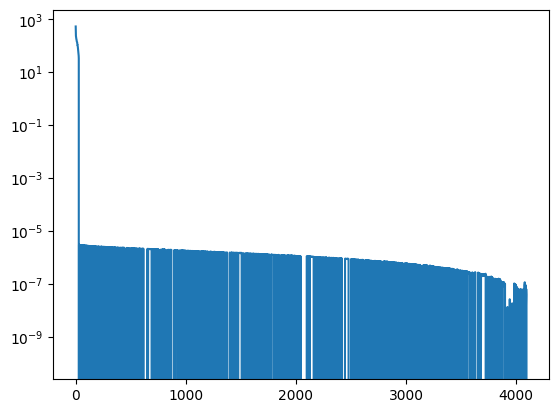

In [17]:
plt.plot(eigen_results.eigenvalues)
plt.yscale('log')

In [45]:
headlines

[{'title': 'US Stocks Limp Into Year End; Treasury Yields Rise: Markets Wrap',
  'title_detail': {'type': 'text/plain',
   'language': None,
   'base': 'https://feeds.bloomberg.com/markets/news.rss',
   'value': 'US Stocks Limp Into Year End; Treasury Yields Rise: Markets Wrap'},
  'summary': 'Stocks and bonds slipped along with gold and silver on the last day of 2025, bringing a subdued close to an otherwise buoyant year across asset classes that saw US equities post their third straight double-digit gain.',
  'summary_detail': {'type': 'text/html',
   'language': None,
   'base': 'https://feeds.bloomberg.com/markets/news.rss',
   'value': 'Stocks and bonds slipped along with gold and silver on the last day of 2025, bringing a subdued close to an otherwise buoyant year across asset classes that saw US equities post their third straight double-digit gain.'},
  'links': [{'rel': 'alternate',
    'type': 'text/html',
    'href': 'https://www.bloomberg.com/news/articles/2025-12-30/stock-m

In [46]:
queries = ["what is gravity", "what is a neural network"]
answers = [
    "Gravity is the tendency of two objects with mass to attract", 
    "A neural network is a computational model that can approximate any function"
]

query_embeddings = model.encode(queries, prompt = "questions to answer")
answer_embeddings = model.encode(answers, prompt = "answers to question")

In [47]:
query_embeddings

array([[ 0.04186259, -0.01174498, -0.01686266, ..., -0.02471016,
         0.00634335,  0.01003005],
       [ 0.00354448,  0.02254109, -0.04757952, ...,  0.00533595,
         0.00233301,  0.00377033]], shape=(2, 4096), dtype=float32)

In [50]:
query_embeddings@answer_embeddings.T

array([[0.7183435 , 0.40953135],
       [0.371858  , 0.7867126 ]], dtype=float32)

In [51]:
(queries[0], answers[0])

('what is gravity',
 'Gravity is the tendency of two objects with mass to attract')

In [52]:
(query_embeddings@answer_embeddings.T)[0][0]

np.float32(0.7183435)

In [55]:
print(f"query and answer are {(queries[0], answers[1])}\n")
print(f"predicted overlap is {(query_embeddings@answer_embeddings.T)[0][1]}")

query and answer are ('what is gravity', 'A neural network is a computational model that can approximate any function')

predicted overlap is 0.4095313549041748


In [57]:
print(f"query and answer are {(queries[0], answers[0])}\n")
print(f"predicted overlap is {(query_embeddings@answer_embeddings.T)[0][0]}")

query and answer are ('what is gravity', 'Gravity is the tendency of two objects with mass to attract')

predicted overlap is 0.7183434963226318


In [58]:
print(f"query and answer are {(queries[1], answers[0])}\n")
print(f"predicted overlap is {(query_embeddings@answer_embeddings.T)[1][0]}")

query and answer are ('what is a neural network', 'Gravity is the tendency of two objects with mass to attract')

predicted overlap is 0.37185800075531006


In [59]:
print(f"query and answer are {(queries[1], answers[1])}\n")
print(f"predicted overlap is {(query_embeddings@answer_embeddings.T)[1][1]}")

query and answer are ('what is a neural network', 'A neural network is a computational model that can approximate any function')

predicted overlap is 0.7867125868797302


In [61]:
headlines[0]

{'title': 'US Stocks Limp Into Year End; Treasury Yields Rise: Markets Wrap',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': 'https://feeds.bloomberg.com/markets/news.rss',
  'value': 'US Stocks Limp Into Year End; Treasury Yields Rise: Markets Wrap'},
 'summary': 'Stocks and bonds slipped along with gold and silver on the last day of 2025, bringing a subdued close to an otherwise buoyant year across asset classes that saw US equities post their third straight double-digit gain.',
 'summary_detail': {'type': 'text/html',
  'language': None,
  'base': 'https://feeds.bloomberg.com/markets/news.rss',
  'value': 'Stocks and bonds slipped along with gold and silver on the last day of 2025, bringing a subdued close to an otherwise buoyant year across asset classes that saw US equities post their third straight double-digit gain.'},
 'links': [{'rel': 'alternate',
   'type': 'text/html',
   'href': 'https://www.bloomberg.com/news/articles/2025-12-30/stock-market-today-d

In [77]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 40960, 'do_lower_case': False, 'architecture': 'Qwen3Model'})
  (1): Pooling({'word_embedding_dimension': 4096, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': True, 'include_prompt': True})
  (2): Normalize()
)